# Software Vulnerability Detection using Deep Learning (Experiment Replication) - Individual Output

In [ ]:
lO

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [66]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [3]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [4]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [5]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

# Create source code sdata for tokenization
x_all = train['functionSource']
x_all = x_all.append(validate['functionSource'])
x_all = x_all.append(test['functionSource'])

In [6]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


### Tokenizing the source codes

In [7]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1207818


In [8]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [9]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [10]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [11]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [12]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [13]:
# Example data
test.iloc[0:5,1:6]

,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


### One-Hot-Enconding (OHE) on the datasets

In [14]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [14]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

### Model Definition (CNN with Gaussian Noise and 1 Output Split)

In [21]:
# Must use non-sequential model building to create branches in the output layer
model = []
tbCallback = []
callbackdir= 'D:\\temp\\cb'


for mod in range(0,5):
    inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
    mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                        output_dim = 13,
                                        input_length = INPUT_SIZE)(inp_layer)
    mid_layers = tf.keras.layers.GaussianNoise(stddev=np.sqrt(0.01))(mid_layers)
    mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
    mid_layers = tf.keras.layers.MaxPool1D(pool_size=50)(mid_layers)
    mid_layers = tf.keras.layers.Flatten()(mid_layers)
    mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
    mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
    output = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
    model.append(tf.keras.Model(inp_layer,output))

    # Define custom optimizers
    adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

    # Compile model with metrics
    model[mod].compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Set callbacks
    
    tbCallback.append(tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                             histogram_freq=1,
                             embeddings_freq=1,
                             write_graph=True, 
                             write_images=True))
    tbCallback[mod].set_model(model[mod])
    
print(model[0].summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 13)           130000    
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 500, 13)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 512)          60416     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 512)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                3277

### Model Training

In [23]:
history = []
for hist in range(0,5):
    mld = 'model/model-epoch-{epoch:02d}-single-%d.hdf5'%(hist)
    ## Create best model callback
    mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                             monitor="val_accuracy",
                                             save_best_only=False, 
                                             mode='auto', 
                                             save_freq='epoch', 
                                             verbose=1)
    
    history.append(model[hist].fit(x = x_train,
              y = y_train[hist],
              validation_data = (x_validate, y_validate[hist]),
              epochs = EPOCHS,
              batch_size = 128,
              verbose =2,
              callbacks=[mcp,tbCallback[hist]]))
    
    with open('history/History-Epoch10-CNN_single_%d'%(hist), 'wb') as file_pi:
        pickle.dump(history[hist].history, file_pi)

Train on 1019471 samples, validate on 127476 samples
Epoch 1/10

Epoch 00001: saving model to model/model-epoch-01-single-0.hdf5
1019471/1019471 - 190s - loss: 0.1461 - accuracy: 0.9797 - val_loss: 0.2214 - val_accuracy: 0.9810
Epoch 2/10

Epoch 00002: saving model to model/model-epoch-02-single-0.hdf5
1019471/1019471 - 185s - loss: 0.0935 - accuracy: 0.9811 - val_loss: 0.2143 - val_accuracy: 0.9810
Epoch 3/10

Epoch 00003: saving model to model/model-epoch-03-single-0.hdf5
1019471/1019471 - 185s - loss: 0.0933 - accuracy: 0.9811 - val_loss: 0.2107 - val_accuracy: 0.9810
Epoch 4/10

Epoch 00004: saving model to model/model-epoch-04-single-0.hdf5
1019471/1019471 - 185s - loss: 0.0931 - accuracy: 0.9811 - val_loss: 0.2065 - val_accuracy: 0.9810
Epoch 5/10

Epoch 00005: saving model to model/model-epoch-05-single-0.hdf5
1019471/1019471 - 184s - loss: 0.0929 - accuracy: 0.9811 - val_loss: 0.1983 - val_accuracy: 0.9810
Epoch 6/10

Epoch 00006: saving model to model/model-epoch-06-single-0.h

### Model Evaluation using Testing Set

In [25]:
model = tf.keras.models.load_model("model/model-epoch-10-single-0.hdf5")
results = model.evaluate(x_test, y_test[0], batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.17256195195536908
accuracy: 0.9807564


In [28]:
### Check The Evaluation Metrics

predicted = model.predict(x_test)

In [41]:
pd.value_counts((predicted > 0.5)[:,0])

True    127419
dtype: int64

In [127]:
pred_test = [[],[],[],[],[]]

for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(1)
        else:
            pred_test[col].append(0)
            
for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

1    127419
dtype: int64
1    127419
dtype: int64
1    127419
dtype: int64
1    127419
dtype: int64
1    127419
dtype: int64


In [122]:
y_test[0]

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [113]:
true_test = [[],[],[],[],[]]

for col in range(0,len(y_test)):
    for row in y_test[col]:
        true_test[col].append(row[0])

for col in range(0,len(true_test)):
    print(pd.value_counts(true_test[col]))

1    124967
0      2452
dtype: int64
1    122528
0      4891
dtype: int64
1    127141
0       278
dtype: int64
1    126227
0      1192
dtype: int64
1    123929
0      3490
dtype: int64


In [ ]:
print('\nConfusion Matrix')
confusion = sklearn.metrics.confusion_matrix(y_true=old_y_test, y_pred=predicted)
print(confusion)

## Performance measure
print('\nWeighted Accuracy: '+ str(sklearn.metrics.accuracy_score(y_true=old_y_test, y_pred=predicted)))
print('Weighted precision: '+ str(sklearn.metrics.precision_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted recall: '+ str(sklearn.metrics.recall_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted f-measure: '+ str(sklearn.metrics.f1_score(y_true=old_y_test, y_pred=predicted, average='weighted')))

### Plot The Model's Training History

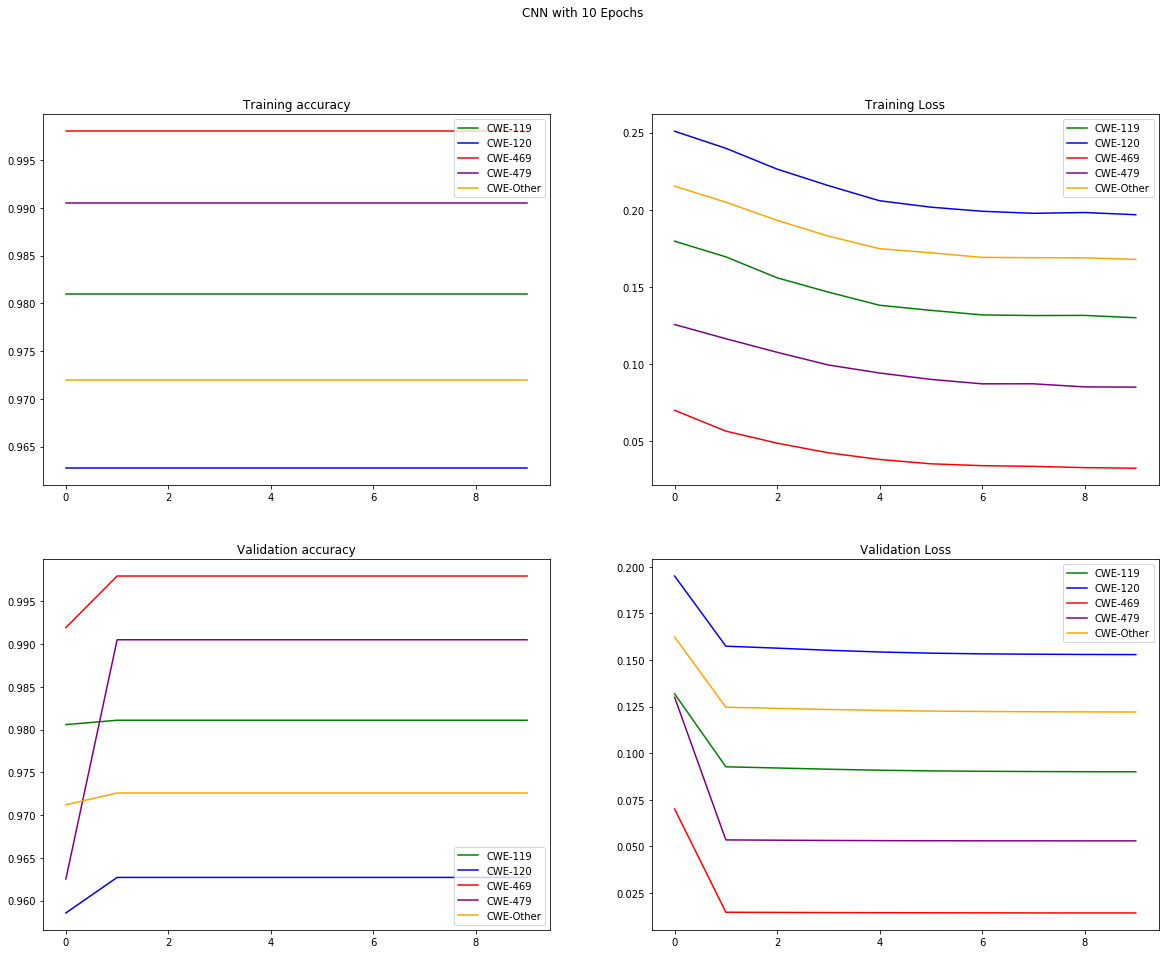

In [34]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')

axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-119', color='green')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-120', color='blue')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-469', color='red')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-479', color='purple')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-Other', color='orange')
axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='CWE-119', color='green')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-120', color='blue')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-469', color='red')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-479', color='purple')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-Other', color='orange')
axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history.history[model.metrics_names[6]], 'b', label='CWE-119', color='green')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[7]], 'b', label='CWE-120', color='blue')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[8]], 'b', label='CWE-469', color='red')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[9]], 'b', label='CWE-479', color='purple')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[10]], 'b', label='CWE-Other', color='orange')
axs[1,0].set_title('Validation accuracy')
axs[1,0].legend()


axs[1,1].plot(epochs_range, history.history[model.metrics_names[1]], 'b', label='CWE-119', color='green')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[2]], 'b', label='CWE-120', color='blue')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[3]], 'b', label='CWE-469', color='red')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[4]], 'b', label='CWE-479', color='purple')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[5]], 'b', label='CWE-Other', color='orange')
axs[1,1].set_title('Validation Loss')
axs[1,1].legend()

